# Instrument cross calibration

Most of the time, when dealing with multiple X-ray instruments, one would want to account for the differences in calibrations between all observatories. The straightforward way to do this with `jaxspec` is to use an [`InstrumentModel`](/references/fitting/#jaxspec.model.instrument.InstrumentModel). Let's first load observations from PN, MOS1 and MOS2.

In [1]:
%%capture
# Hide the output of this cell
import numpyro

numpyro.enable_x64()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

import numpyro.distributions as dist
from jaxspec.fit import MCMCFitter
from jaxspec.data.util import load_example_obsconf
from jaxspec.model.additive import Blackbodyrad, Powerlaw
from jaxspec.model.multiplicative import Tbabs
from jaxspec.model.background import BackgroundWithError

spectral_model = Tbabs()*(Powerlaw() + Blackbodyrad())

obsconfs = load_example_obsconf("NGC7793_ULX4_ALL")

prior = {
    "powerlaw_1_alpha": dist.Uniform(1, 3),
    "powerlaw_1_norm": dist.LogUniform(1e-5, 1e-3),
    "blackbodyrad_1_kT": dist.Uniform(0, 2),
    "blackbodyrad_1_norm": dist.LogUniform(1e-2, 1),
    "tbabs_1_nh": dist.Uniform(0, 1)
}

An [`InstrumentModel`](/references/fitting/#jaxspec.model.instrument.InstrumentModel) can be constructed by joining a [`GainModel`](/references/fitting/#jaxspec.model.instrument.GainModel) and a [`ShiftModel`](/references/fitting/#jaxspec.model.instrument.ShiftModel), and requires an instrument that will be the reference. For instance, in the following observations, we will use the PN one, and specify it using `"PN"` as it is the key corresponding to this observation in the dictionary of observations we use.

In [2]:
import numpyro.distributions as dist
from jaxspec.model.background import BackgroundWithError
from jaxspec.model.instrument import InstrumentModel, ConstantGain, ConstantShift

fitter = MCMCFitter(
    spectral_model , prior , obsconfs,
    instrument_model = InstrumentModel(
        "PN",
        gain_model=ConstantGain(dist.Uniform(0.5, 1.5)), # Uniform between 50 % and 150% of calibration error
        shift_model=ConstantShift(dist.Uniform(-0.5, +0.5)) # Assume a shift betwen -500 and + 500 eV
    ),
    background_model=BackgroundWithError()
)

Now lets fit the data as usual

In [3]:
result = fitter.fit(num_chains=4, num_warmup=1000, num_samples=1000)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

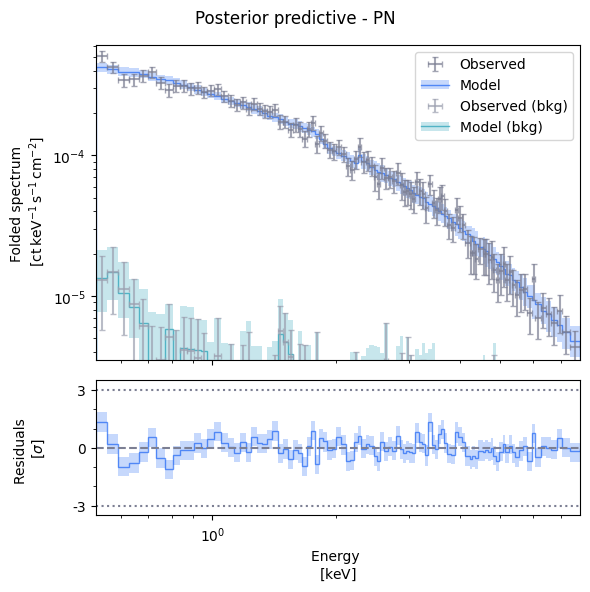

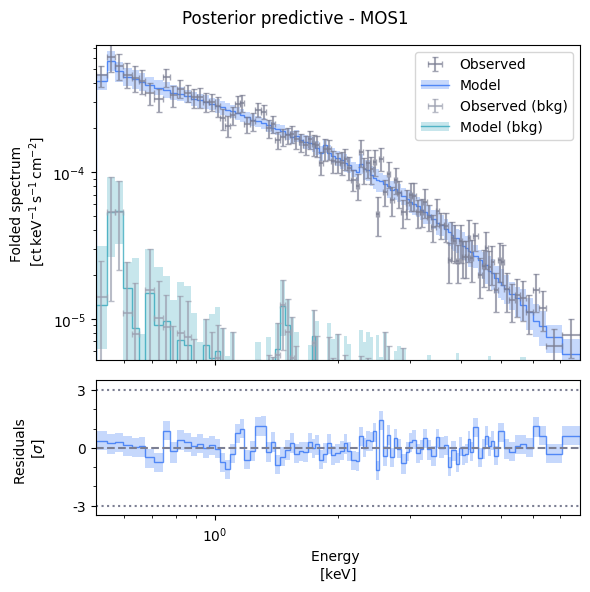

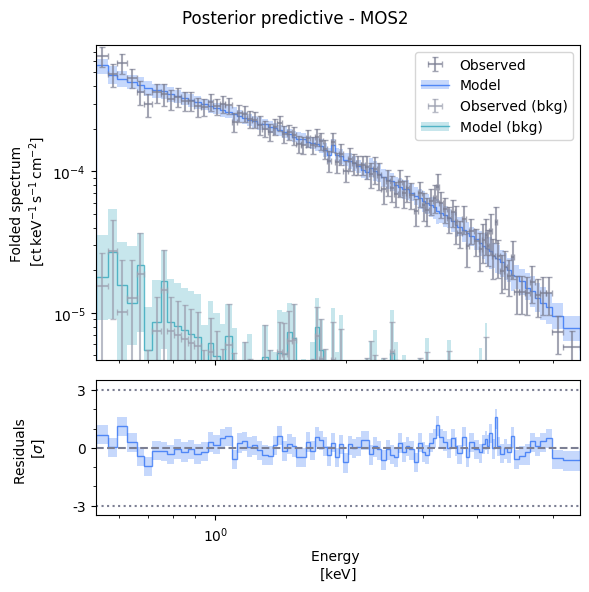

In [4]:
result.plot_ppc();

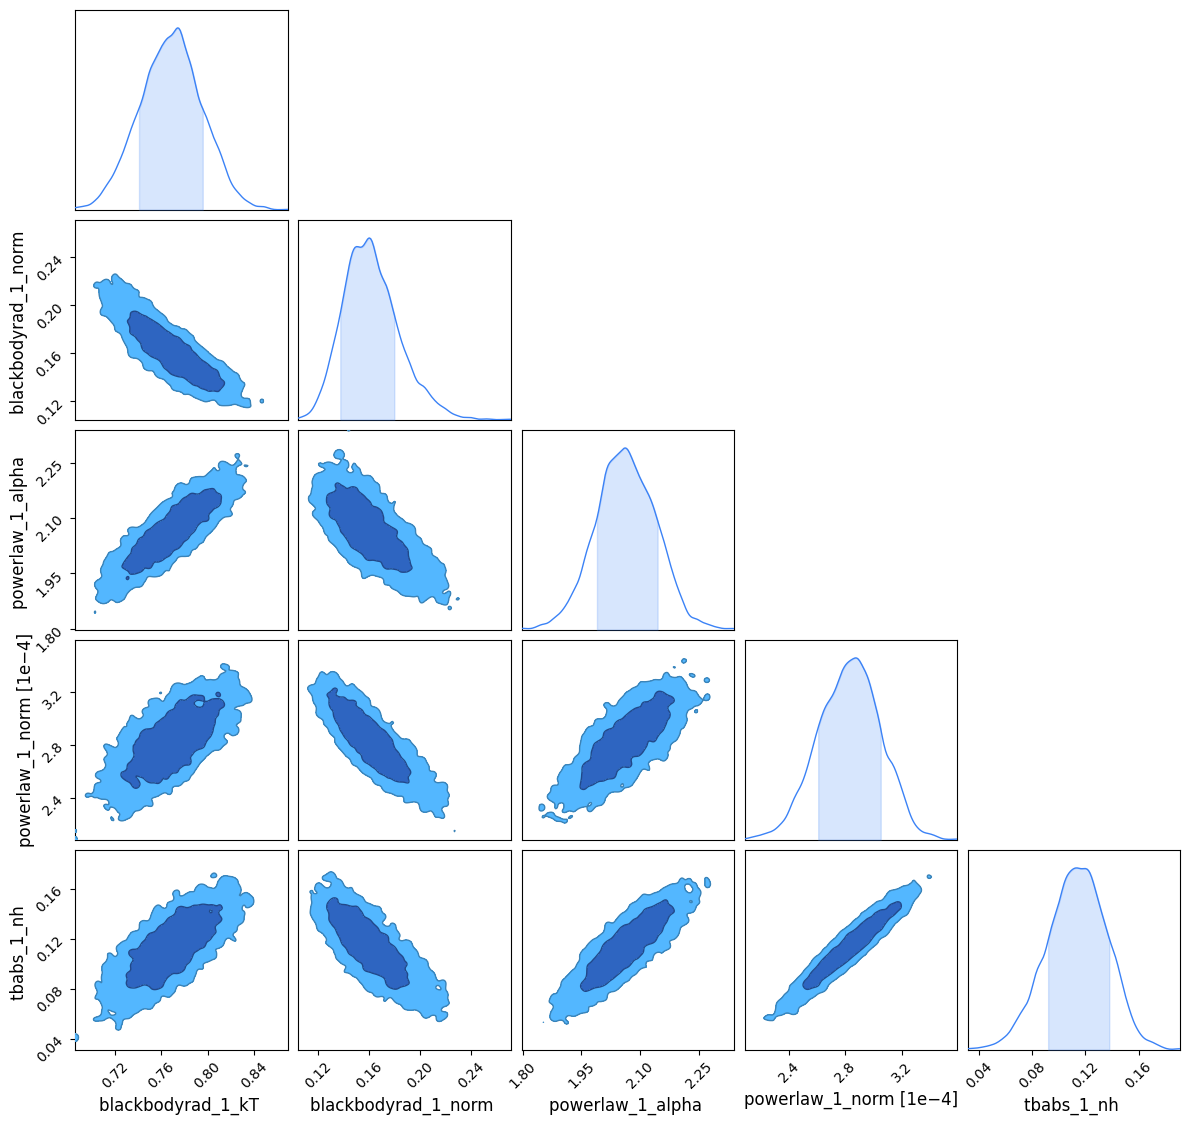

In [5]:
result.plot_corner()

The associated calibrations can be found in the `result` object and accessed as follows

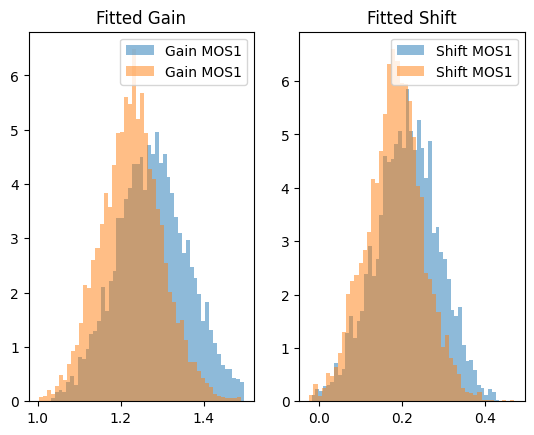

In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')
plt.subplot(121)
plt.hist(np.ravel(result.inference_data.posterior["ins/~/gain_MOS1"]), label="Gain MOS1", alpha=0.5, bins=50, density=True)
plt.hist(np.ravel(result.inference_data.posterior["ins/~/gain_MOS2"]), label="Gain MOS1", alpha=0.5, bins=50, density=True)
plt.title("Fitted Gain")
plt.legend()

plt.subplot(122)
plt.hist(np.ravel(result.inference_data.posterior["ins/~/shift_MOS1"]), label="Shift MOS1", alpha=0.5, bins=50, density=True)
plt.hist(np.ravel(result.inference_data.posterior["ins/~/shift_MOS2"]), label="Shift MOS1", alpha=0.5, bins=50, density=True)
plt.title("Fitted Shift")
plt.legend()
plt.show()